<h3 align="center"> 3D Volume Registration with Gaussian Process </h3>

Import all required packages

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import os
import time
from sklearn.gaussian_process import GaussianProcess

In [3]:
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')
from visualize import plot_cost_func

#1. Getting Data

In [4]:
data_dict = pickle.load(open('/Users/zyzdiana/GitHub/AC297r-Volume-Registration/Thesis/data_dict.p','rb'))

#2. Methods
## 2.1. Initial Exploration with Scikit-learn

We know that suppose we have a function vector $ f=(f(x_1),...f(x_n))$, and if for any choice of input points, $(x_1,...,x_n)$, the marginal distribution over f:$P(F) = \int_{f \not\in F} P(f) df$ is multi-variate Gaussian, then the distribution over the function f is said to be a Gaussian Process. To address our problem, we formulate the interpolation using Gaussian Process. Recall that to detect motion, we need to rotate the volumes in positions 2, 3 and 4 and examine how close the rotated volumes are to the reference volume. To rotate a given volume $V$, the first step is to rotate the cartesian grid of the volume, and then the values on the rotated grid need to be interpolated. We will employ a Gaussian process (GP) prior over the volumes and assume Gaussian noise on the observations. Hence the voxel values of the volumes at positinos 2, 3 and 4 serve as observations and use Gaussian Process to predict values on the rotated grids of those volumes.

We define the Gaussian Process for our problem as:

$$f(x) \sim \mathcal{GP}(m(x), k(x,x\prime))$$

where $x$ is the coordinates of the voxels, $f(x)$ is the values at each voxel. The mean and covariance functions can be thought of as the infinite dimensionam mean vector and covariance matrix respectively.

Let's take the size $(32 \times 32 \times32)$ of the volume as an example, the $x$ of the Gaussian Process would be ${(0,0,0), (0,0,1),...,(0,1,0),(0,1,1),...,(31,31,31)}$, which will result in a $(32768 \times 32768)$ covariance matrix. The covariance matrix is too big for our computation, so we reduce the dimensions of the data to speed up computations. The volumes at positions 2, 3, and 4 are rotations along only 1 axis; hence we can slice the volumes into 2D images and run Gaussian Process on the 2D image, which will only have a covariance matrix of size $(1024 \times 1024)$. The code below runs the GP defined above using Scikit-learn.

First, define some helper functions for rotating grids. The rotation matrix in 2D is as follows,

$$R(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta \\
\end{bmatrix}$$

If we need to rotate the point (x,y) by $\theta$ degrees counterclock wise, then the coordinates for the new point is 
$(\cos \theta x + \sin\theta y, \sin\theta x+\cos\theta y)$

In [5]:
def to_radian(theta):
    '''
    convert the given theta in degrees to radian
    '''
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta degrees about the
    center(ox, oy).

    """
    # convert
    theta = to_radian(theta)
    s, c = np.sin(theta), np.cos(theta)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

We used scikit learn to try rotations of 45 degrees and visulized the rotated images. There are typically two ways taking 2D slices out of a 3D volume, the first methods is simply to take a slice in one direction out of the volume. THe second methods is called maximum projection, and for 2D maximum projection, each pixel in the projection is the maximum value of the original volume along the orthogonal direction axis of the slice. Maximum prjection produces stronger intensity in the images, given such small pixel values, we will use the maximum projection of the volume to demonstrate the results of Gaussian Process Interpolation. (Please note that we are only using Scikit Learn to get a general idea of how GP works on the volumetric data, hence we will not try to do any registration with scikit learn, only rotations with GP interpolation.)

In [6]:
def generate_X(n):
    '''
    Generate x for Gaussian Process
    Inputs
        n - dimension of volume
    Output:
        X - (n*n, 2) matrix for Gaussian Process
    '''
    X = np.zeros([n*n,2])
    count = 0
    for i in xrange(n):
        for j in xrange(n):
            X[count]=np.array([i,j])
            count += 1
    return X

# generate X_pred
def get_x_pred(theta, n=32):
    '''
    Generate X coordinates for Predictions
    Inputs:
        theta - rotation angle in degrees
        n - image dimension
    Output:
        X_pred - (n*n,2) matrix for prediction
    '''
    # rotate coordinates
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,(n-1.0)/2.0,(n-1.0)/2.0)
    
    # Use the roated coordinates to generate x for prediciton
    X_pred = np.zeros([n*n,2])
    count = 0
    for i in xrange(n):
        for j in xrange(n):
            X_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
            count += 1
    return X_pred

The following cells shows a 45-degree rotation using Gaussian Process in all given reolutions.

In [7]:
# get some test data with 5mm resolution
# head coil
head_iso_5mm = data_dict['5mm']['head']['iso'][0]
head_5deg_LR_5mm = data_dict['5mm']['head']['LR']['5deg'][0]
head_5deg_AP_5mm = data_dict['5mm']['head']['AP']['5deg'][0]
# body coil
body_iso_5mm = data_dict['5mm']['body']['iso'][0]
body_5deg_LR_5mm = data_dict['5mm']['body']['LR']['5deg'][0]
body_5deg_AP_5mm = data_dict['5mm']['body']['AP']['5deg'][0]

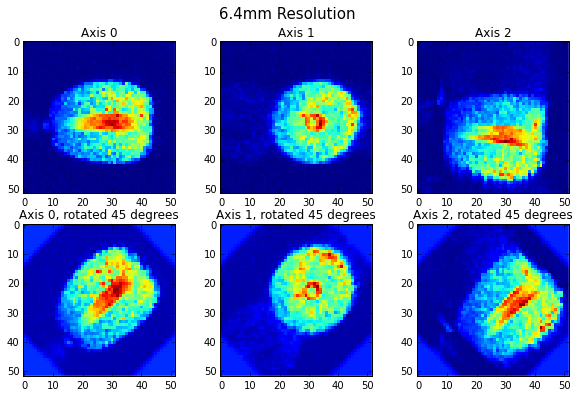

In [8]:
# 5mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(52)

# Prediction Coordinates
theta = 45
n = 52
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=10, thetaL=50, thetaU=200)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(head_iso_5mm.max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = head_5deg_LR_5mm.max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('6.4mm Resolution\n', fontsize=15)
plt.show()

In [8]:
# get some test data
# head coil
head_iso_6_4mm = data_dict['6_4mm']['head']['iso'][0]
head_5deg_LR_6_4mm = data_dict['6_4mm']['head']['LR']['5deg'][0]
head_5deg_AP_6_4mm = data_dict['6_4mm']['head']['AP']['5deg'][0]
# body coil
body_iso_6_4mm = data_dict['6_4mm']['body']['iso'][0]
body_5deg_LR_6_4mm = data_dict['6_4mm']['body']['LR']['5deg'][0]
body_5deg_AP_6_4mm = data_dict['6_4mm']['body']['AP']['5deg'][0]

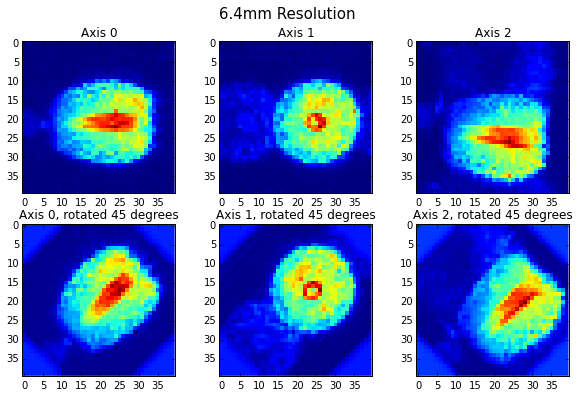

In [10]:
# 6.4mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(40)

# Prediction Coordinates
theta = 45
n = 40
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=10, thetaL=50, thetaU=200)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(head_iso_6_4mm.max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = head_5deg_LR_6_4mm.max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('6.4mm Resolution\n', fontsize=15)
plt.show()

In [9]:
# get some test data with 5mm resolution
# head coil
head_iso_8mm = data_dict['8mm']['head']['iso'][0]
head_5deg_LR_8mm = data_dict['8mm']['head']['LR']['5deg'][0]
head_5deg_AP_8mm = data_dict['8mm']['head']['AP']['5deg'][0]
# body coil
body_iso_8mm = data_dict['8mm']['body']['iso'][0]
body_5deg_LR_8mm = data_dict['8mm']['body']['LR']['5deg'][0]
body_5deg_AP_8mm = data_dict['8mm']['body']['AP']['5deg'][0]

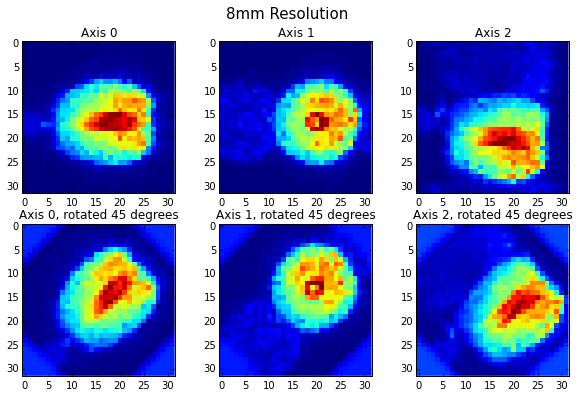

In [15]:
# 8mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(32)

# Prediction Coordinates
theta = 45
n = 32
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=1, thetaL=0.1, thetaU=100)

# Run GP for three axis
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(head_iso_8mm.max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = head_iso_8mm.max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('8mm Resolution\n', fontsize=15)
plt.show()

In [10]:
# get some test data with 5mm resolution
# head coil
head_iso_10mm = data_dict['10mm']['head']['iso'][0]
head_5deg_LR_10mm = data_dict['10mm']['head']['LR']['5deg'][0]
head_5deg_AP_10mm = data_dict['10mm']['head']['AP']['5deg'][0]
# body coil
body_iso_10mm = data_dict['10mm']['body']['iso'][0]
body_5deg_LR_10mm = data_dict['10mm']['body']['LR']['5deg'][0]
body_5deg_AP_10mm = data_dict['10mm']['body']['AP']['5deg'][0]

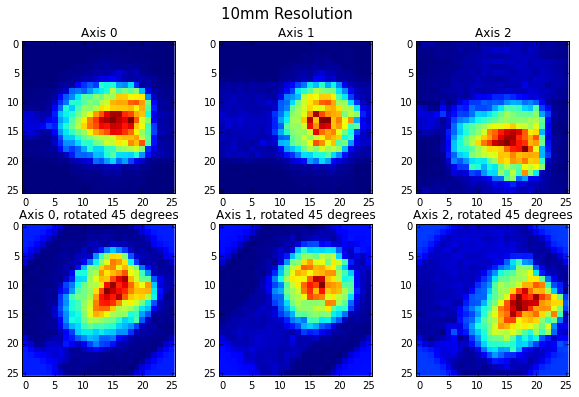

In [17]:
# 10mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(26)

# Prediction Coordinates
theta = 45
n = 26
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=1, thetaL=0.1, thetaU=100)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(head_iso_10mm.max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = head_iso_10mm.max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('10mm Resolution\n', fontsize=15)
plt.show()

## 2.2 Maximum Likelihood of GP

Now that we know how to run Gaussian Process on the data, we will implement Gaussian Process and find optimal parameters for GP. The kernel function for GP is the squared exponential kernel defined as
$$k(x, x′) = \exp (−l ∥x − x′∥^2).$$ (We have also explored different distance measure in the kernel function, for example L1 distance, cubic distance; however normed distance turned out to be the best measure)

When concerned with a general Gaussian process regression problem, it is assumed that for a Gaussian process $f$ observed at coordinates x, the vector of values $f(x)$ is just one sample from a multivariate Gaussian distribution of dimension equal to number of observed coordinates $|x|$. Therefore under the assumption of a zero-mean distribution, $f (x) ∼ N (0, K(l,x,x'))$, where $K(l,x,x')$ is the covariance matrix between all possible pairs $(x,x')$ for a given $l$. As such the log marginal likelihood is:

\begin{align*}
\log p(f(x)|l,x) =  -\frac{1}{2}f(x)^T K(l,x,x')^{-1} f(x) -\frac{1}{2} \log \det(K(l,x,x')) - \frac{|x|}{2} \log 2\pi 
\end{align*}

We use maximum likelihood estimation to find the optimal $l$. We perform gradient ascend to get the value. First, we calculate the gradient of the log marginal likelihood:
\begin{align*}
\frac{d\log p(f(x)| l, x)}{dl} 
&= \frac{d}{dl} \left(-\frac{1}{2}f(x)^T K(l,x,x')^{-1} f(x) -\frac{1}{2} \log \det(K(l,x,x')) - \frac{|x|}{2} \log 2\pi\right)\\
&= -\frac{1}{2}f(x)^T \frac{d K(l,x,x')^{-1}}{dl} f(x) -\frac{1}{2} \frac{d \log \det(K(l,x,x'))}{dl} \\
&= -\frac{1}{2}f(x)^T (-K(l,x,x')^{-1} \frac{d K(l,x,x')}{dl} K(l,x,x')^{-1}) f(x) -\frac{1}{2 \det(K(l,x,x'))} tr\left(adj(K(l,x,x')) \frac{d K(l,x,x')}{dl}\right) \\
&= \frac{1}{2}f(x)^T (K^{-1} \frac{d K}{dl} K^{-1}) f(x) -\frac{1}{2 \det(K)} tr(adj(K) \frac{d K}{dl})
\end{align*}

First, define functions for the kernel function and calculating covariance matrix.

In [11]:
### define the kernel function
def exponential_kernel(x_1, x_2, l=1.0): 
    return np.exp(np.sum((x_1 - x_2)**2, axis=2) * (-l))

### define the function to get the covariance matrix
def get_cov_matrix(kernel, xx1, xx2, l=1.0):
    xx = np.arange(0, xx1.shape[0])
    yy = np.arange(0, xx2.shape[0])
    mesh_x,mesh_y = np.meshgrid(xx,yy)
    
    sigma = exponential_kernel(xx1[mesh_x], xx2[mesh_y], l)  
    return sigma

Define function that computes the likelihood as defined above. Then use gradient ascend to find $l$ that gives maximum likelihood.

In [12]:
# kernel after gradient
def der_exponential_kernel(x_1, x_2, l): 
    return -np.sum((x_1 - x_2)**2, axis=2)*np.exp( -l* np.sum((x_1 - x_2)**2, axis=2) ) 

# log-likelihood
def Likelihood(X, y, l=1.0, sigma_noise_square=0.0):
    K = get_cov_matrix(exponential_kernel, X,X,l)
    
    sigma_noise_sq = np.ones(K.shape[0])*sigma_noise_square
    K_noise = K + np.diag(sigma_noise_sq)
    
    K_inv = np.linalg.inv(K_noise)
        
    L = np.linalg.cholesky(K)
    log_det = 2*np.sum(np.log(L.diagonal()))

    return -1./2.*np.dot(np.dot(y.T, K_inv), y) - 1./2.*log_det-X.shape[0]/2.*np.log(2*np.pi)

# gradient of log-likelihood
def grad_likelihood(X, Y, l=1.0):
    K_grad = get_cov_matrix(der_exponential_kernel, X, X, l)
    K = get_cov_matrix(exponential_kernel, X, X, l)
    K_inv = np.linalg.inv(K)
    a = np.trace(np.dot(K_inv, K_grad))
    b = np.dot(np.dot(np.dot(np.dot(Y, K_inv), K_grad), K_inv), Y)
    
    return -a/2.-b/2.

def gradient_ascent(l0, gradient, X, Y, alpha=0.02, sigma_noise_square=0.0):
    l = l0
    l_old = l
    likeli = Likelihood(X, Y, l, sigma_noise_square)
    likelihoods = []
    ls = []
    print "Initial Likelihood:", likeli, "L:", l
    while(True):
        grad = gradient(X, Y, l)
        l_old = l
        likeli_old = likeli
        l += alpha*grad
        count = 1
        
        # l must be greater than zero
        while l<0:
            count+=1
            l = l_old + alpha**count*grad
            
        likeli = Likelihood(X, Y, l, sigma_noise_square)
        
        if(abs(likeli_old-likeli)<0.001):
            break
    print "Done!"
    print "Likelihood:", likeli, "L:", l
    return l

## 2.3 Implement GP using optimized parameter 

Since the rigid movements are known, the range for thetas will be true movement $\theta +/- 0.5$. As mentioned above, the cost function we use to compare the rotated image with the reference image is the sum of squared differences (SSD) between the two images. The function belows computes SSD cost function.

In [13]:
# SSD cost function
def cf_ssd(J, I):
    return np.sum((J-I)**2)

## 2.4 Data Normalization

When we imput data into GP, the data was not normalized, and because values for observations are very small (on an average of $1\times 10^{-3}$), such small numbers makes registration very difficult, so we will noralize the data.

The function below runs the same GP with the squared exponential kernel, but with normalized input data.

In [14]:
# Gaussian processes with normalization
def Gaussian_processes_2D_norm(X, Y, X_pred, l=1.0, sigma_noise_square=0.0):
    
    '''
    Interpolates a 2D image using GP with normalization
    Inputs:
        X - X coordinates of the observation
        Y - Pixel values of the observation
        X_pred - X coordinates of the prediction
        l - parameter for GP
        sigma_noise_square - noise for covariance matrix
    Output:
        y_pred - interpolated image with GP predictions with normalization
    '''
    
    # normalize input data
    if Y.ndim == 1:
        Y = Y[:, np.newaxis]
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    X_std[X_std == 0.] = 1.
    Y_std[Y_std == 0.] = 1.
    
    # center and scale
    X_norm = (X - X_mean) / X_std
    Y_norm = (Y - Y_mean) / Y_std
    X_pred_norm = (X_pred - X_mean) / X_std
    
    # Gaussian Process
    K = get_cov_matrix(exponential_kernel, X_norm,X_norm,l)
    
    sigma_noise_sq = np.ones(K.shape[0])*sigma_noise_square
    K_noise = K + np.diag(sigma_noise_sq)
        
    K_noise_inv = np.linalg.inv(K_noise)

    K_star = get_cov_matrix(exponential_kernel,X_norm, X_pred_norm, l)
    K_star_star = get_cov_matrix(exponential_kernel,X_pred_norm, X_pred_norm)

    mu_star = np.dot(np.dot(K_star.T, K_noise_inv), Y_norm)
    
    # scale back to original scale
    Y_pred = mu_star * Y_std + Y_mean
    
    return np.reshape(Y_pred, Y_pred.shape[0])

As before, run Likelihood to find the optimal $l$ before GP.

In [15]:
# generate X
n = 52
X = generate_X(n)

# Image at Position 2
Y = head_5deg_LR_5mm[n/2,:,:].ravel()

# Reference image
Y_ref = head_iso_5mm[n/2,:,:].ravel()

# Normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

In [140]:
# Perform gradient ascent to normed data
l_norm = gradient_ascent(40, grad_likelihood, X_norm, Y_norm, alpha=0.1)

In [ ]:
l_norm = 149.18601899

In [54]:
from mask import circle_mask

In [72]:
# generate X
n = 32
X = generate_X(n)

# Image at Position 2
Y = circle_mask(head_5deg_AP_8mm[n/2,:,:],smooth=True).ravel()

# Reference image
Y_ref = circle_mask(head_iso_8mm[n/2,:,:],smooth=True).ravel()

In [81]:
import ghalton
N = 5000
s = (n-1)/2.
sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
sequencer.reset()
points = sequencer.get(N)
pts = np.array(points)
xx1 = (n - 1) * pts[:,0] - s
yy1 = (n - 1) * pts[:,1] - s
mask = np.sqrt(xx1**2+yy1**2) < s*0.7
x1 = xx1[mask]
y1 = yy1[mask]

In [82]:
gp = GaussianProcess(theta0=10, thetaL=50, thetaU=200)
gp.fit(X, Y_ref)
#new_x, new_y = rotate_coords(x1,y1,0,(n-1.0)/2.0,(n-1.0)/2.0)
X_ref_h = np.hstack([x1.reshape([len(x1),1]),y1.reshape([len(y1),1])])
Y_ref_h = gp.predict(X_ref_h)

In [83]:
# result of GP with normaliation sklearn
# larger range
costs = []
thetas = np.arange(-6,6,0.1)
gp2 = GaussianProcess(theta0=10, thetaL=50, thetaU=200)
gp2.fit(X, Y)
for theta in thetas:
    print theta,
    new_x, new_y = rotate_coords(x1,y1,theta,(n-1.0)/2.0,(n-1.0)/2.0)
    X_pred_h = np.hstack([new_x.reshape([len(new_x),1]),new_y.reshape([len(new_y),1])])
    Y_pred_h = gp2.predict(X_pred_h)
    c = cf_ssd(Y_pred_h, Y_ref_h)
    costs.append(c)

-6.0 -5.9 -5.8 -5.7 -5.6 -5.5 -5.4 -5.3 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.0 -3.9 -3.8 -3.7 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.0 -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.0 -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1 -2.13162820728e-14 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.0 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.0 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9


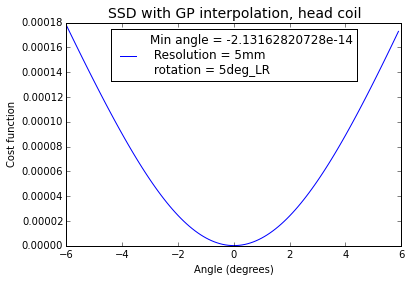

In [84]:
# plot results with sklearn
plot_cost_func(thetas, costs, '5mm', 'GP','5deg_LR', 'head')

Run the same sample slice using GP with normalization.

In [141]:
# result of GP with normaliation sklearn
# larger range
sigma_noise = 0.0
costs = []
thetas = np.arange(-6,-4,0.1)
gp = GaussianProcess(theta0=10, thetaL=50, thetaU=200)
gp.fit(X, Y)
for theta in thetas:
    x_pred = get_x_pred(theta, n=52)
    print theta,
    #print theta, gp.theta_,
    y_pred = gp.predict(x_pred)
    #y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l_norm)
    c = cf_ssd(y_pred, Y_ref)
    costs.append(c)

-6.0 -5.9 -5.8 -5.7 -5.6 -5.5 -5.4 -5.3 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1


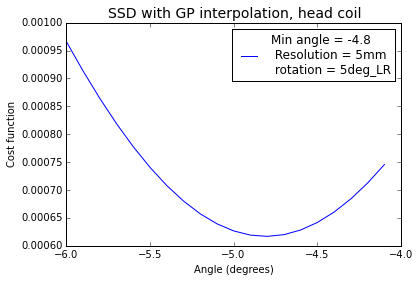

In [103]:
# plot results with sklearn
plot_cost_func(thetas, costs, '5mm', 'GP','5deg_LR', 'head')

With data normalization, we have improved the results and GP can now find the accurate angle (5 degrees) for rotation. We will use this method to run all of the data and compare the accuracy for different resolution.

# 3. Results

In this section, we will show the cost functions for data from all three resolutions and rotations along all axis using the methodology developed above. Recall that in the previous sections, we are using a sample slice of the data, now for the final results, we will run GP with normalization on every slice of the 3D volume to reconstruct the rotated volume in 3D. There will be a total of 9 results, 3 for each resolution, and for each resolution, there is one result for rotation along one axis. The results will be shown by the plot of the cost function, and the angle that gives the minimum cost will be the final result for a rotation in a given resolution.

In [142]:
def GP_cost(vol_ref, vol_rot, n, thetas, axis):
    # 5mm rotation along axis 0
    t0 = time.time()

    s = (n-1)/2.
    X = generate_X(n)

    cost_func = []
    gp = GaussianProcess(theta0=10, thetaL=50, thetaU=50000)
    for theta in thetas:
        print theta,
        xx = np.linspace(0,n-1,n)
        yy = np.linspace(0,n-1,n)
        mesh_x, mesh_y = np.meshgrid(xx,yy)
        new_vol = np.empty([n,n,n])
        for idx in xrange(n):
            # Get Y
            if(axis == 0):
                Y = vol_rot[idx,:,:].ravel()
            if(axis == 1):
                Y = vol_rot[:,idx,:].ravel()
            if(axis == 2):
                Y = vol_rot[:,:,idx].ravel()
            # Get X after rotation
            x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
            x_pred = np.zeros([n*n,2])
            count = 0
            for i in xrange(n):
                for j in xrange(n):
                    x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                    count += 1

            # Predict Y
            gp.fit(X, Y)
            y_pred = gp.predict(x_pred)
            #y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
            if(axis == 0):
                new_vol[idx,:,:] = y_pred.reshape([n,n])
            if(axis == 1):
                new_vol[:,idx,:] = y_pred.reshape([n,n])
            if(axis == 2):
                new_vol[:,:,idx] = y_pred.reshape([n,n])
        cost_func.append(cf_ssd(new_vol, vol_ref))
    t1 = time.time()
    print 'time: ', t1-t0
    return cost_func

In [143]:
def res_to_voxel(res):
    '''
    converts resolution to its corresponding voxel
    '''
    if(res == '5mm'):
        return 52
    if(res == '6_4mm'):
        return 40
    if(res == '8mm'):
        return 32
    if(res == '10mm'):
        return 26

In [ ]:
# repetition 0
# dictionary to store results
cost_dict = {}

rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
#resolutions = ['5mm','6_4mm','8mm','10mm']
resolutions = ['5mm']
for res in resolutions:
    cost_dict[res] = {}
    n = res_to_voxel(res)
    for rot in rot_axes:
        cost_dict[res][rot] = {}
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-1,-d+1,0.1)
                cost = GP_cost(data_dict[res][coil]['iso'][0], data_dict[res][coil][rot][deg][0], n, thetas, axis = ax)
                cost_dict[res][rot][deg] = cost

In [146]:
pickle.dump(cost_dict,open('cost_dict_5.p','wb'))

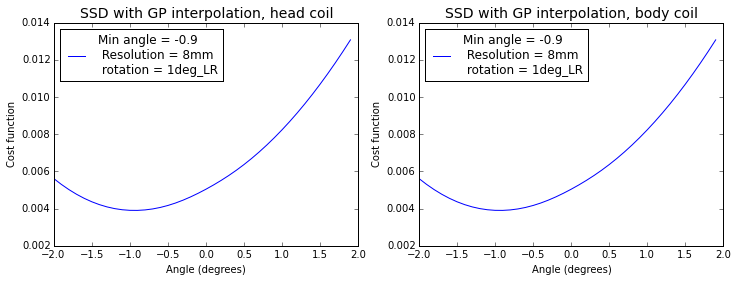

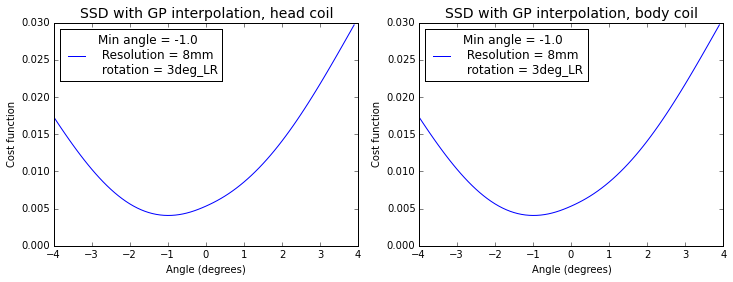

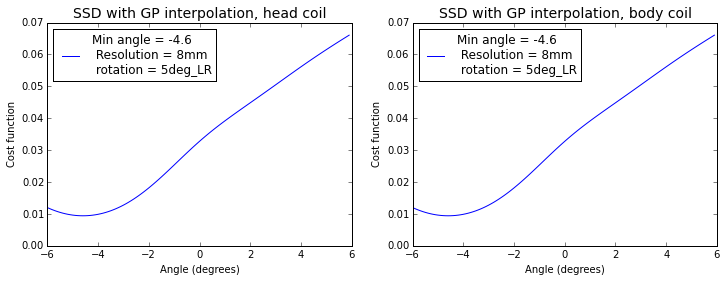

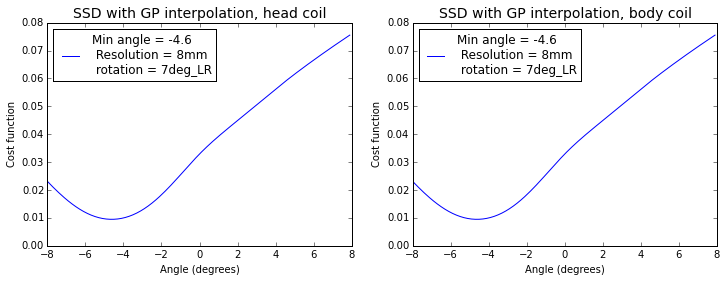

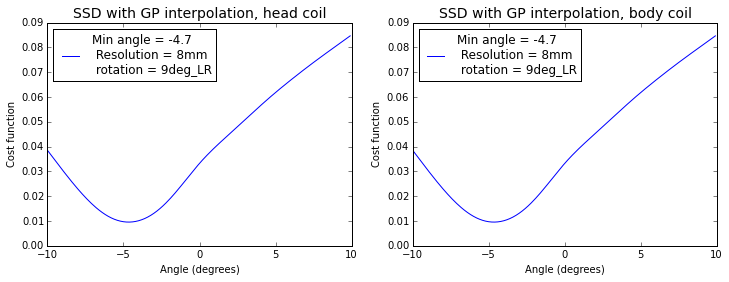

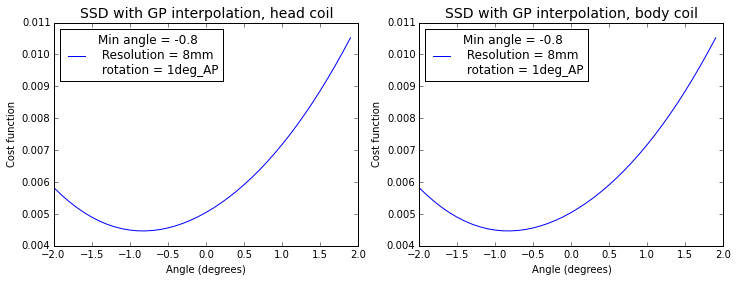

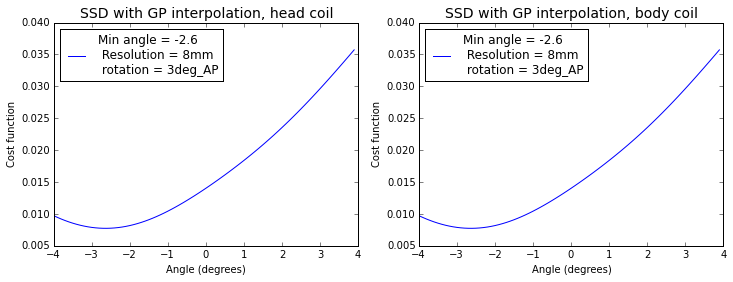

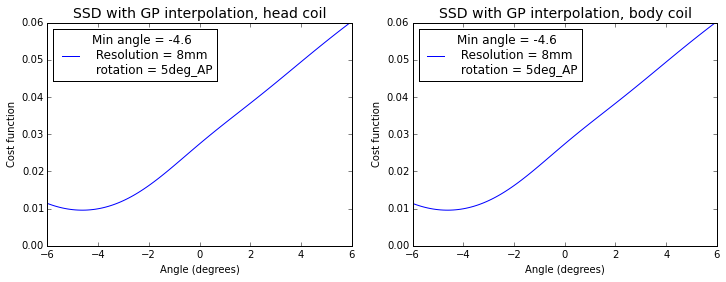

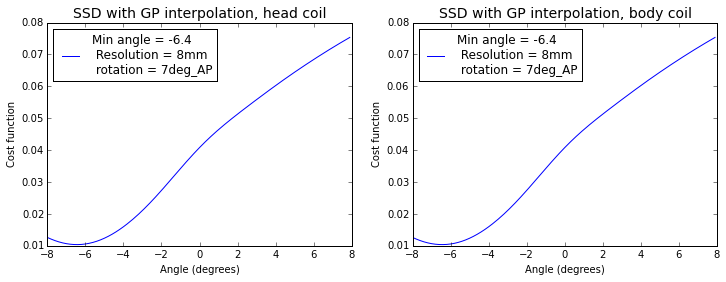

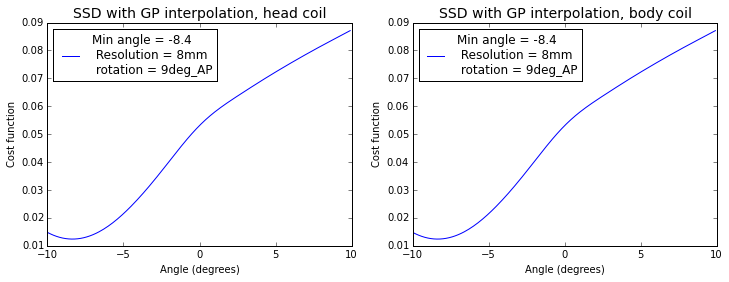

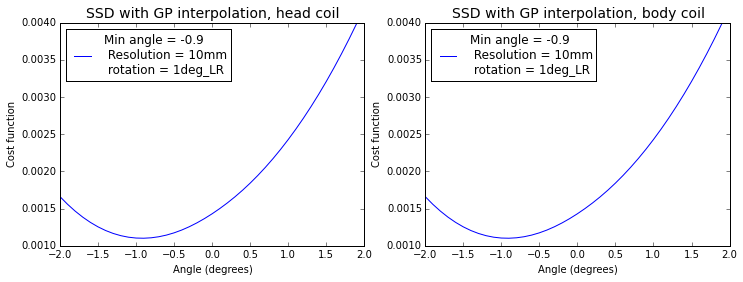

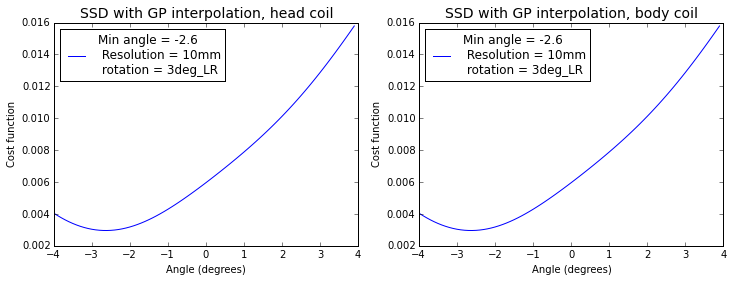

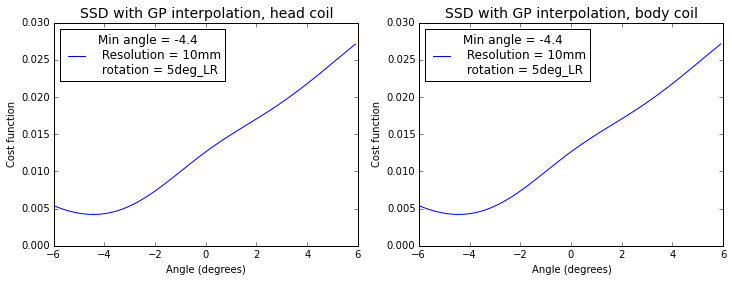

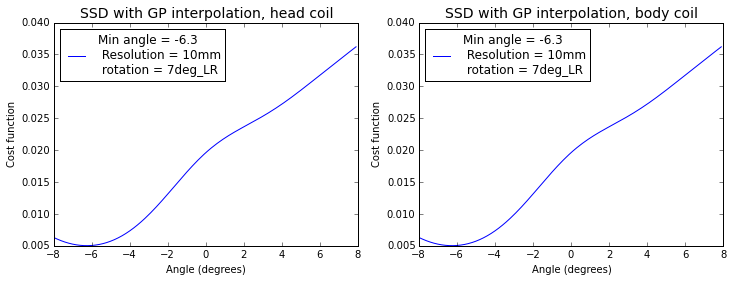

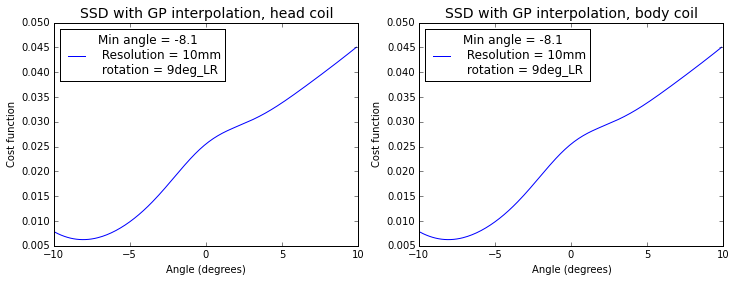

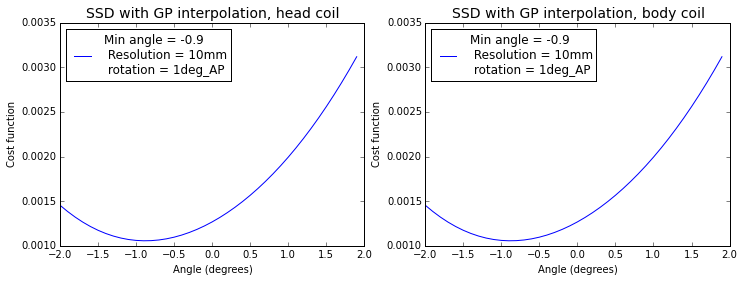

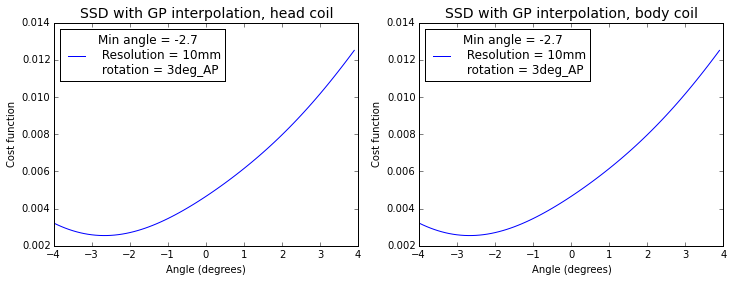

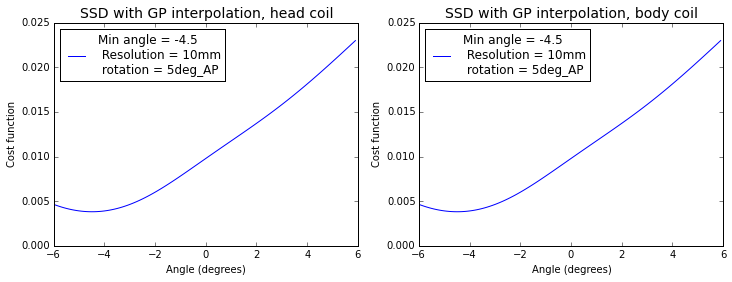

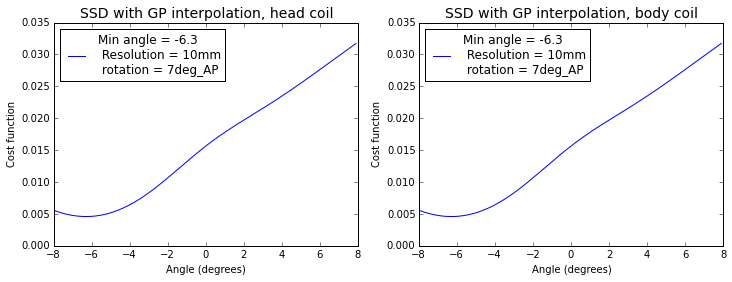

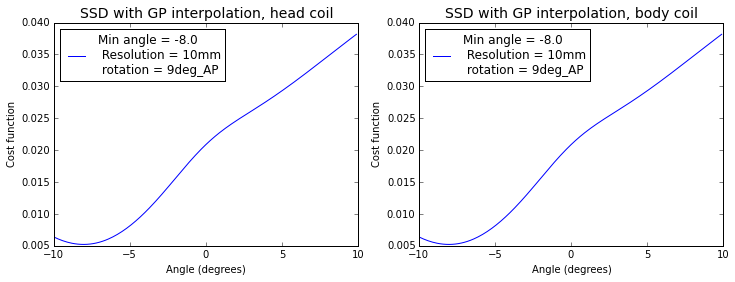

In [27]:
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['8mm','10mm']
for res in resolutions:
    n = res_to_voxel(res)
    for rot in rot_axes:
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                plt.subplot(1,2,idx+1)
                d = int(deg[0])
                thetas = np.arange(-d-1,d+1,0.1)
                plot_cost_func(thetas, cost_dict[res][rot][deg], res, 'GP',deg+'_'+rot, coil)
            plt.show()

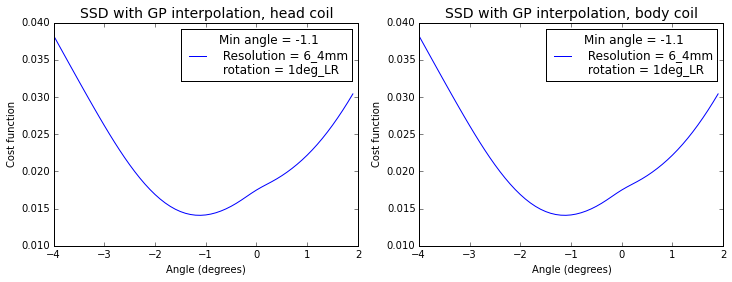

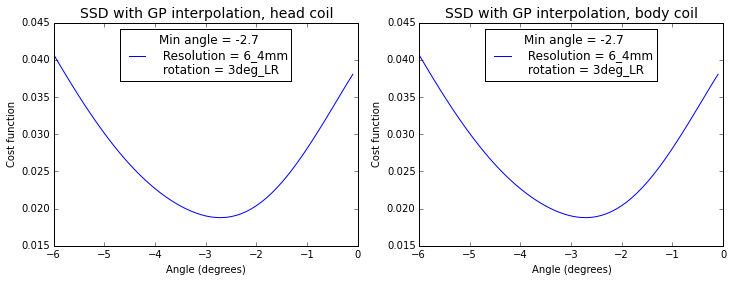

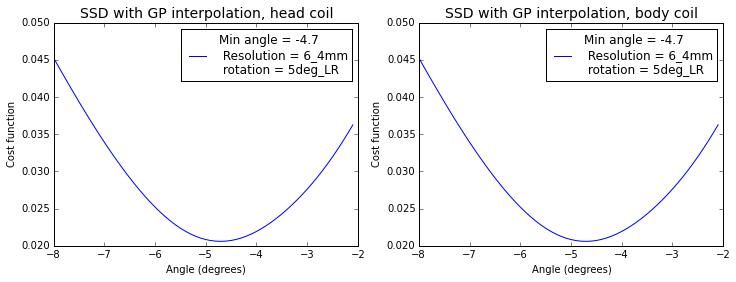

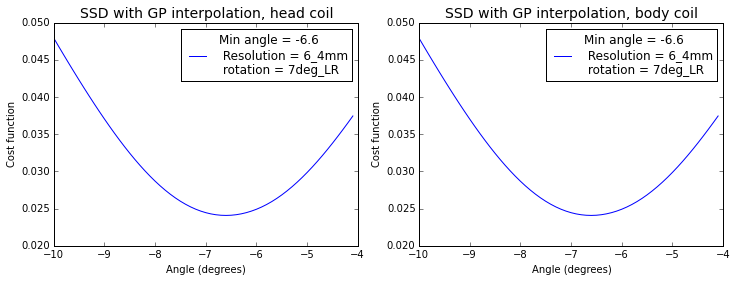

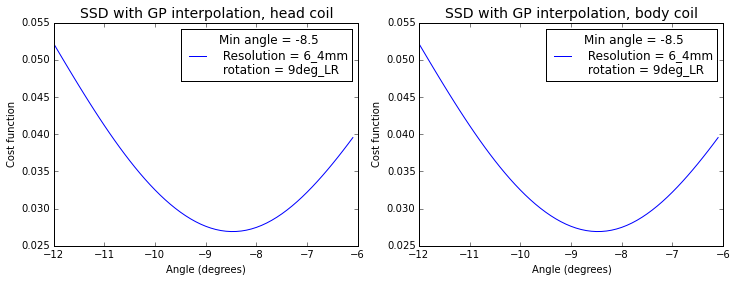

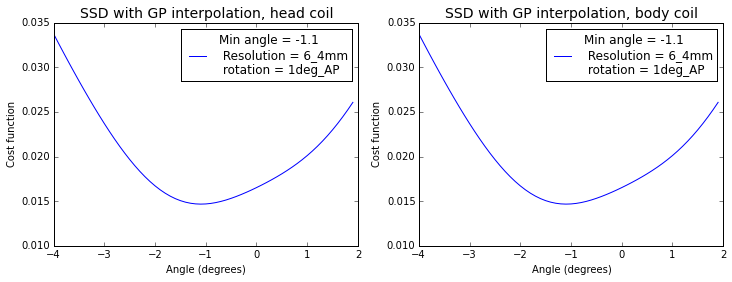

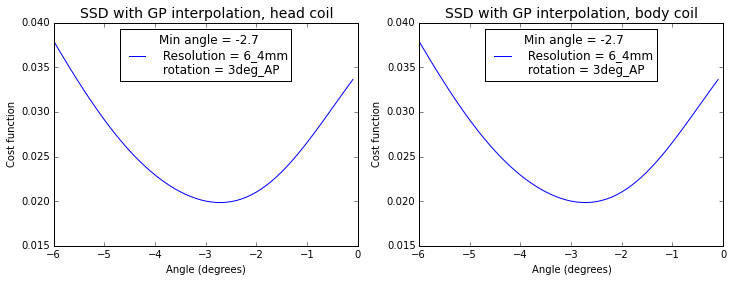

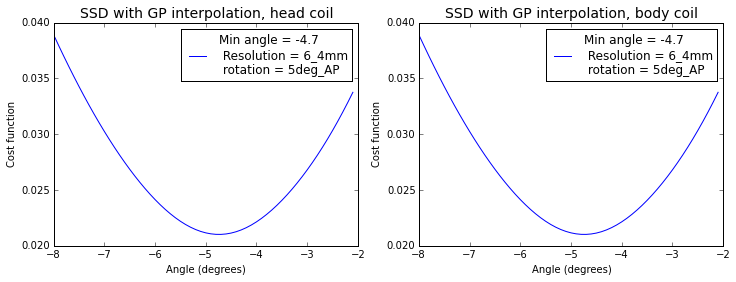

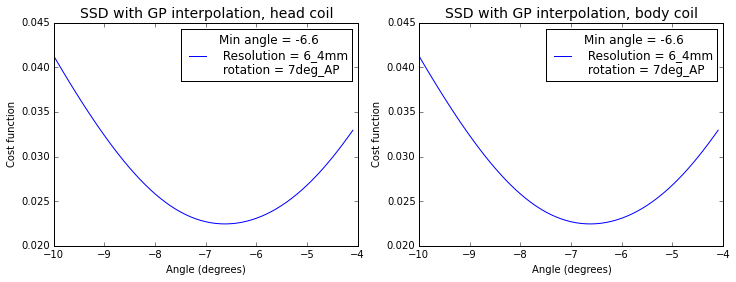

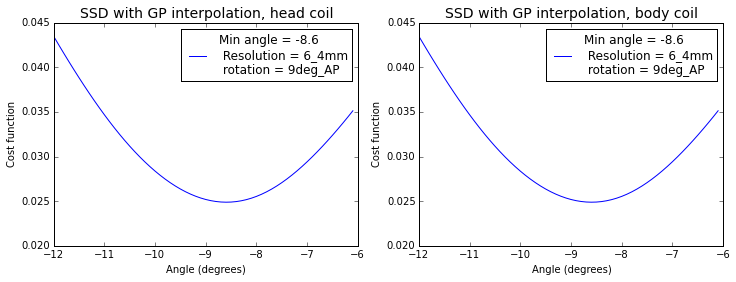

In [151]:
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['6_4mm']
for res in resolutions:
    n = res_to_voxel(res)
    for rot in rot_axes:
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                plt.subplot(1,2,idx+1)
                d = int(deg[0])
                thetas = np.arange(-d-3,-d+3,0.1)
                plot_cost_func(thetas, cost_dict[res][rot][deg], res, 'GP',deg+'_'+rot, coil)
            plt.show()